DATA LOADING

In [98]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from gradient_delay import *

# SFOAE data loading
mat_SFOAE = scipy.io.loadmat(
    'data/SFOAE/sfoae20dBg130TM45R19rs2.mat')

freq_SFOAE = mat_SFOAE['Fvect'].flatten()  # frequency axis
SFOAE = mat_SFOAE['oaeNum20'].flatten()  # SFOAE wave
CRcomp = mat_SFOAE['CRc20'].flatten()  # CR component
NLcomp = mat_SFOAE['Yunl20'].flatten()  # NL component

group_delay_orig = calcDelay(freq_SFOAE, SFOAE)


OBTAINING TIME DOMAIN (IFFT: P(f) -> p(t))

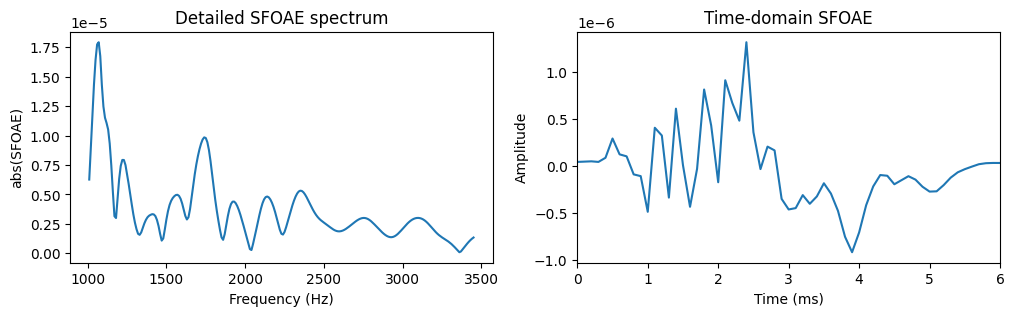

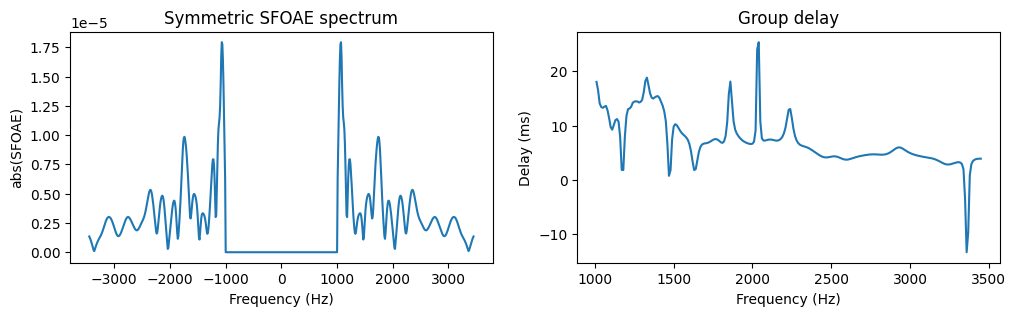

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


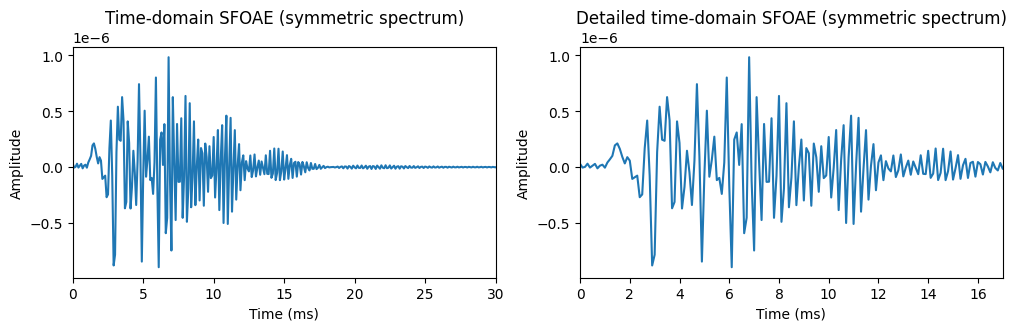

In [99]:
time_SFOAE = np.fft.ifft(SFOAE)
sample_freq = 10000 # random estimate (not known)
time_axis = np.arange(len(time_SFOAE))/sample_freq  # 1000 --> ms

# creating a symmetric spectrum of SFOAE data
freq_step = freq_SFOAE[1] - freq_SFOAE[0]
zeros_num = int(freq_SFOAE[0]/freq_step) - 1
positive_spectrum = np.concatenate((np.zeros(zeros_num), SFOAE))
symmetric_spectrum = np.concatenate((np.conjugate(np.flip(positive_spectrum)), np.array([0]), positive_spectrum))
freq_symmetric = np.arange(-1*freq_SFOAE[-1], freq_SFOAE[-1]+1, freq_step)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
ax1.plot(freq_SFOAE, np.abs(SFOAE))
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('abs(SFOAE)')
ax1.set_title("Detailed SFOAE spectrum")

ax2.plot(1000*time_axis, time_SFOAE.real)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Amplitude')
ax2.set_title("Time-domain SFOAE")
ax2.set_xlim(0, 6)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
ax1.plot(freq_symmetric, np.abs(symmetric_spectrum))
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('abs(SFOAE)')
ax1.set_title("Symmetric SFOAE spectrum")

ax2.plot(freq_SFOAE, 1000*group_delay_orig)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Delay (ms)')
ax2.set_title("Group delay")
plt.show()

time_sym_SFOAE = np.fft.ifft(symmetric_spectrum)
sample_freq_sym = 10000  # random estimate (not known)
time_axis_sym = np.arange(len(time_sym_SFOAE))/sample_freq_sym  # 1000 --> ms

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
ax1.plot(1000*time_axis_sym, time_sym_SFOAE.real)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Amplitude')
ax1.set_title("Time-domain SFOAE (symmetric spectrum)")
ax1.set_xlim(0, 30)

ax2.plot(1000*time_axis_sym, time_sym_SFOAE)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Amplitude')
ax2.set_title("Detailed time-domain SFOAE (symmetric spectrum)")
ax2.set_xlim(0, 17)

plt.show()


CWT MOLETI ALGORITHM (FREQUENCY DOMAIN)

In [100]:
# Morlet mother wavelet
def mother_wavelet(t):
    return np.exp(2*np.pi*1j*t)*np.exp(-(t**2))

# ---------------------------------------------------------------------
# SYMMETRICAL SPECTRUM
# scales and all wavelets in a matrix (rows~wavelets, cols~scales)
scales = np.arange(1, 2) # random guess (1-1)
wavelet_matrix = np.zeros((np.size(scales), np.size(time_axis_sym)), dtype=np.complex128)
for i, scale in enumerate(scales):
    wavelet_matrix[i, :] = mother_wavelet(time_axis_sym / scale)

# FFT of all wavelets (w.r.t. wavelets)
wavelet_fft = np.fft.fft(wavelet_matrix, axis=0)
# multiplication with SFOAE spectrum
mult_matrix = wavelet_fft * symmetric_spectrum

# obtaining filtered CWT coefficients (w.r.t. frequency)
cwt_coeff = np.fft.ifft(mult_matrix, axis=1)

# reconstruct the filtered spectrum
filtered_wavelet_fft = np.fft.fft(cwt_coeff, axis=1) # w.r.t. time (-> frequency)
filtered_spectrum = np.sum(filtered_wavelet_fft * wavelet_fft, axis=0)

first_freq_index = np.size(freq_symmetric) - np.size(freq_SFOAE)
oneside_filtered_spectrum_sym = filtered_spectrum[first_freq_index:]
# ---------------------------------------------------------------------
# ORIGINAL SPECTRUM
wavelet_matrix = np.zeros(
    (np.size(scales), np.size(time_axis)), dtype=np.complex128)
for i, scale in enumerate(scales):
    wavelet_matrix[i, :] = mother_wavelet(time_axis / scale)

# FFT of all wavelets (w.r.t. wavelets)
wavelet_fft = np.fft.fft(wavelet_matrix, axis=0)
# multiplication with SFOAE spectrum
mult_matrix = wavelet_fft * SFOAE

# obtaining filtered CWT coefficients (w.r.t. frequency)
cwt_coeff = np.fft.ifft(mult_matrix, axis=1)

# reconstruct the filtered spectrum
filtered_wavelet_fft = np.fft.fft(
    cwt_coeff, axis=1)  # w.r.t. time (-> frequency)
filtered_spectrum = np.sum(filtered_wavelet_fft * wavelet_fft, axis=0)

# first_freq_index = np.size(freq_symmetric) - np.size(freq_SFOAE)
# filtered_spectrum = filtered_spectrum[first_freq_index:]


DISPLAYING FILTERED SPECTRA

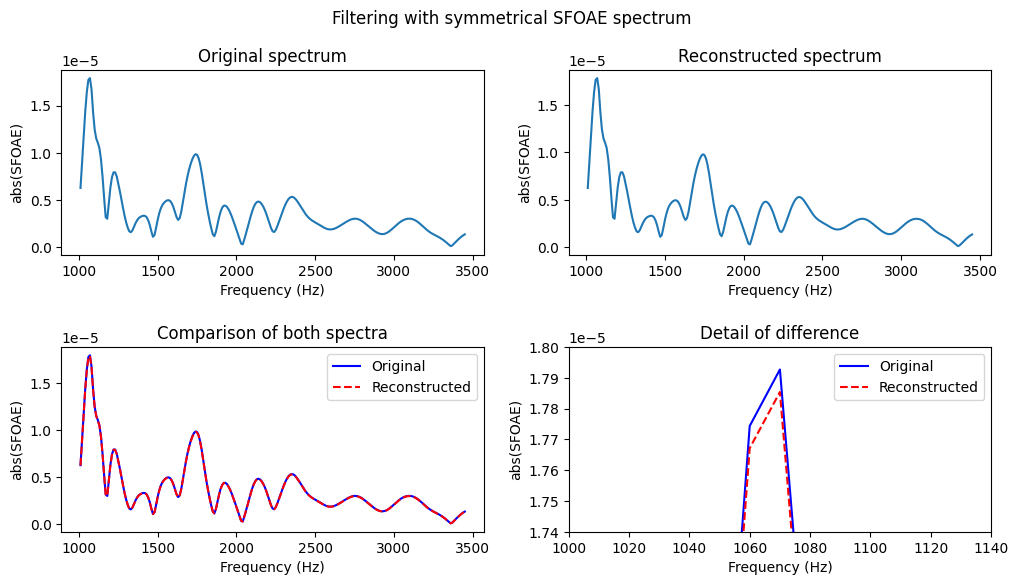

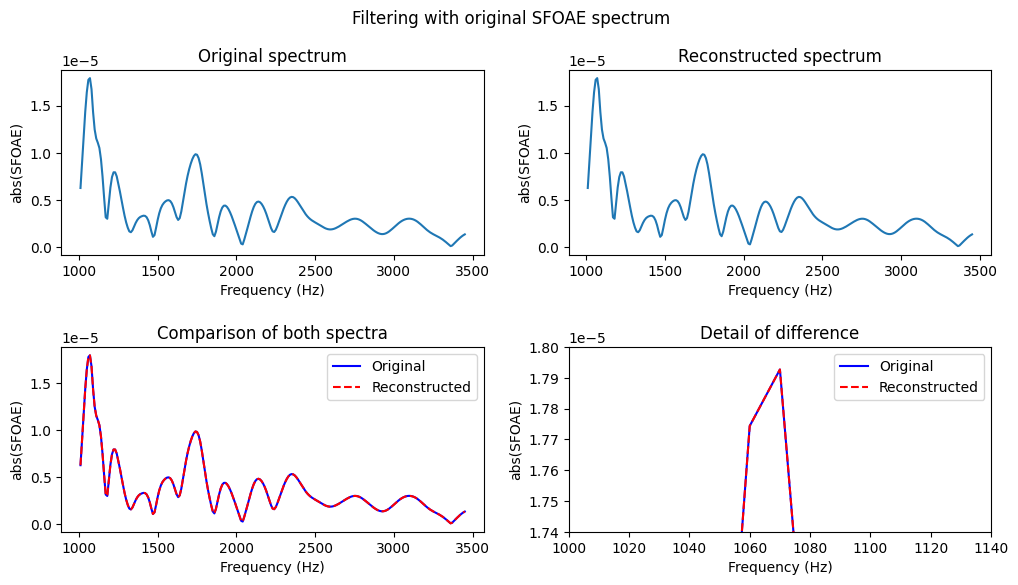

In [101]:
# --------------------------------------------------------
# SYMMETRICAL SPECTRUM
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
fig.suptitle("Filtering with symmetrical SFOAE spectrum")
ax1.plot(freq_SFOAE, np.abs(SFOAE))
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('abs(SFOAE)')
ax1.set_title("Original spectrum")

ax2.plot(freq_SFOAE, np.abs(oneside_filtered_spectrum_sym))
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('abs(SFOAE)')
ax2.set_title("Reconstructed spectrum")
# --------------------------------------------------------
ax3.plot(freq_SFOAE, np.abs(SFOAE), "b", label="Original")
ax3.plot(freq_SFOAE, np.abs(oneside_filtered_spectrum_sym),
         "r--", label="Reconstructed")
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('abs(SFOAE)')
ax3.legend()
ax3.set_title("Comparison of both spectra")

ax4.plot(freq_SFOAE, np.abs(SFOAE), "b", label="Original")
ax4.plot(freq_SFOAE, np.abs(oneside_filtered_spectrum_sym),
         "r--", label="Reconstructed")
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('abs(SFOAE)')
ax4.legend()
ax4.set_xlim(1000, 1140)
ax4.set_ylim(1.74*1e-5, 1.8*1e-5)
ax4.set_title("Detail of difference")

plt.subplots_adjust(hspace=0.5)
plt.show()

# --------------------------------------------------------
# SFOAE SPECTRUM
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
fig.suptitle("Filtering with original SFOAE spectrum")
ax1.plot(freq_SFOAE, np.abs(SFOAE))
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('abs(SFOAE)')
ax1.set_title("Original spectrum")

ax2.plot(freq_SFOAE, np.abs(filtered_spectrum))
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('abs(SFOAE)')
ax2.set_title("Reconstructed spectrum")
# --------------------------------------------------------
ax3.plot(freq_SFOAE, np.abs(SFOAE), "b", label="Original")
ax3.plot(freq_SFOAE, np.abs(filtered_spectrum),
         "r--", label="Reconstructed")
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('abs(SFOAE)')
ax3.legend()
ax3.set_title("Comparison of both spectra")

ax4.plot(freq_SFOAE, np.abs(SFOAE), "b", label="Original")
ax4.plot(freq_SFOAE, np.abs(filtered_spectrum),
         "r--", label="Reconstructed")
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('abs(SFOAE)')
ax4.legend()
ax4.set_xlim(1000, 1140)
ax4.set_ylim(1.74*1e-5, 1.8*1e-5)
ax4.set_title("Detail of difference")

plt.subplots_adjust(hspace=0.5)
plt.show()


DISPLAYING DELAY RESULTS

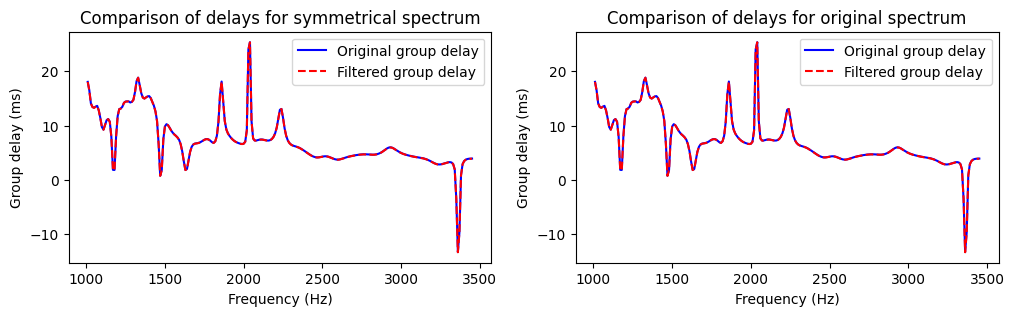

In [102]:
group_delay_filtered_sym = calcDelay(freq_SFOAE, oneside_filtered_spectrum_sym)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
ax1.plot(freq_SFOAE, 1000*group_delay_orig, "b", label="Original group delay")
ax1.plot(freq_SFOAE, 1000*group_delay_filtered_sym,
         "r--", label="Filtered group delay")
ax1.legend()
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Group delay (ms)")
ax1.set_title("Comparison of delays for symmetrical spectrum")

group_delay_orig = calcDelay(freq_SFOAE, SFOAE)
group_delay_filtered = calcDelay(freq_SFOAE, filtered_spectrum)

ax2.plot(freq_SFOAE, 1000*group_delay_orig, "b", label="Original group delay")
ax2.plot(freq_SFOAE, 1000*group_delay_filtered,
        "r--", label="Filtered group delay")
ax2.legend()
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Group delay (ms)")
ax2.set_title("Comparison of delays for original spectrum")
plt.show()
